# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Project code is adapted from Udacity Self-Driving Car Nanodegree Lectures.

# Load pickled data
import pickle
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# TODO: fill this in based on where you saved the training and testing data
training_file = '../../traffic-sign-data/train.p'
testing_file = '../../traffic-sign-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = (len(X_train[0]), len(X_train[1]))

# TODO: how many classes are in the dataset
n_classes = len(np.unique(np.concatenate((y_train,y_test))))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


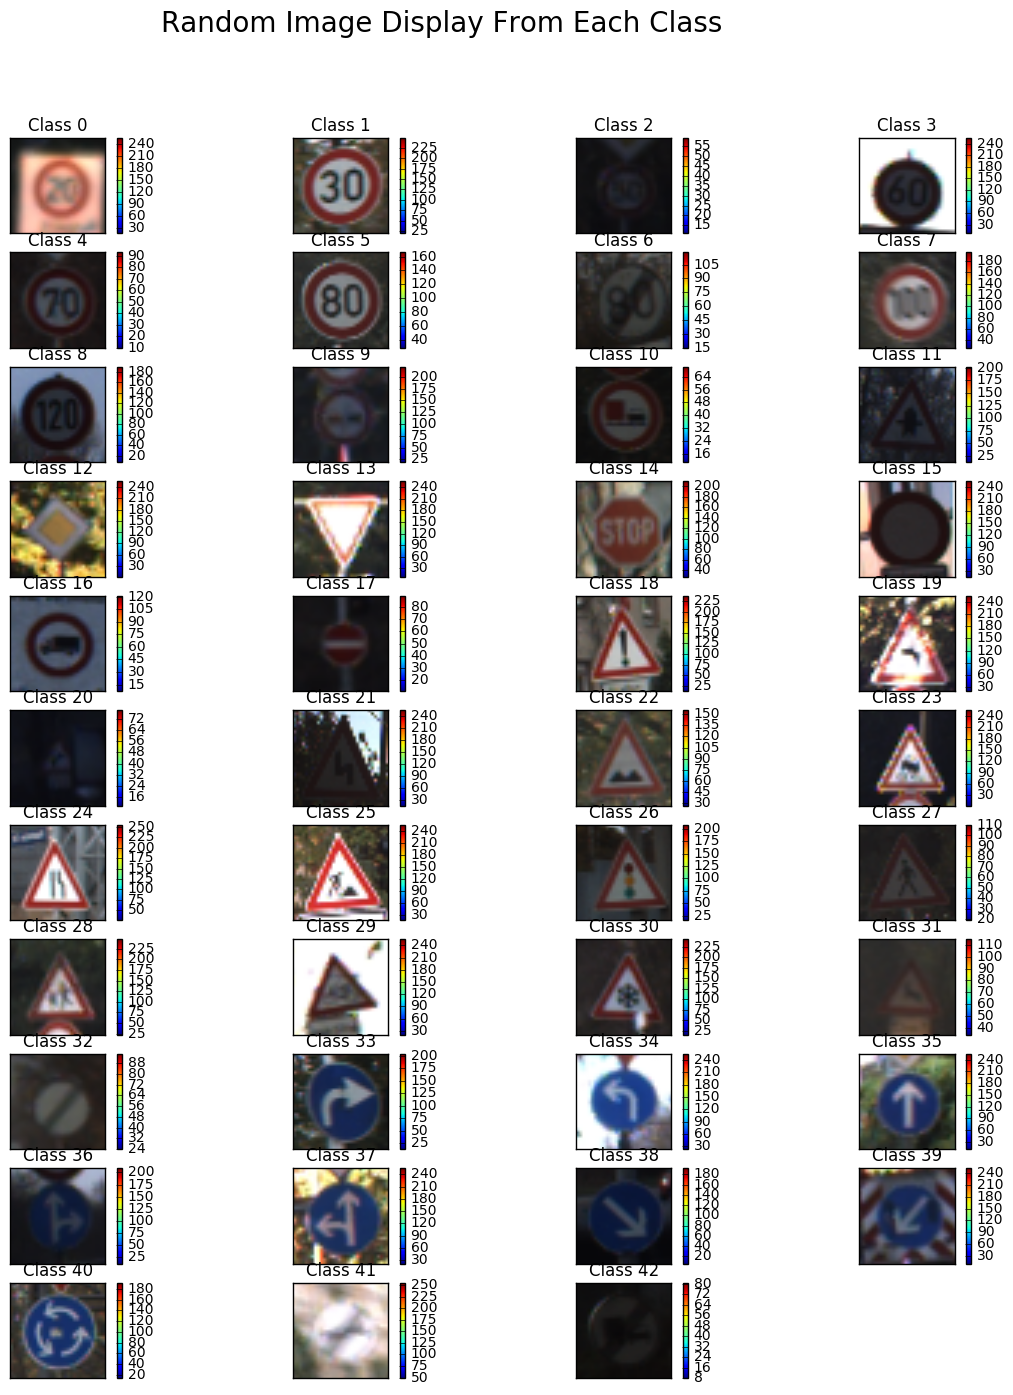

In [50]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Categorize each class in the dataset into a dictionary
data_classes = {}
for i, v in enumerate(X_train):
    if data_classes.get(y_train[i]) is None:
        data_classes[y_train[i]] = [X_train[i]]
    else:
        data_classes[y_train[i]].append(X_train[i])

# Show one random image from each class to get a sense of the images
num_classes = len(data_classes.keys())

plt.clf()
fig = plt.figure(figsize=(14,16));
fig.suptitle('Random Image Display From Each Class', fontsize=20)
rows = num_classes//4 + 1
columns = 4
for i in range(num_classes):
    a=fig.add_subplot(rows,columns,i+1);
    a.set_xticks([])
    a.set_yticks([])
    a.set_title('Class {0}'.format(i))
    plt.imshow(data_classes[i][np.random.randint(len(data_classes[i]))]);
    plt.colorbar();

plt.show()

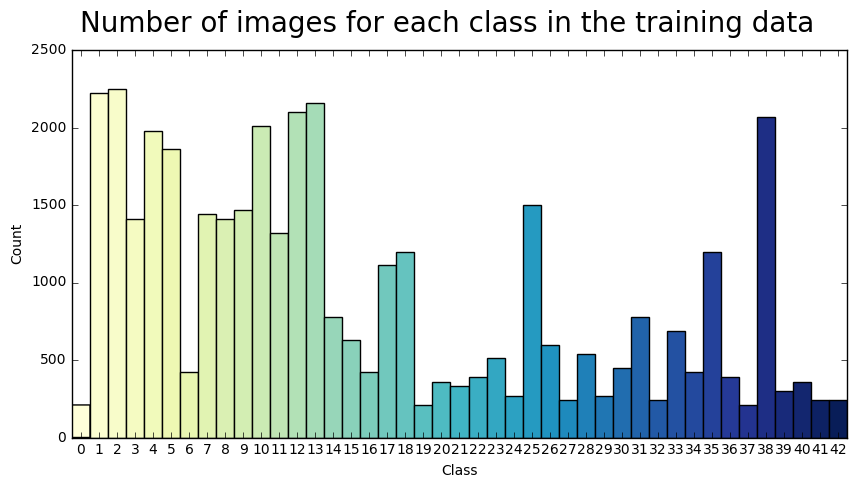

In [51]:
### Plot histograms of the Number of images for each class in the training data
plt.clf()
colormap = plt.cm.get_cmap('YlGnBu')
fig = plt.figure(figsize=(10,5))
fig.suptitle('Number of images for each class in the training data', fontsize=20)
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(range(num_classes))
n, bins, patches = plt.hist(y_train, bins=np.arange(num_classes+1)-0.5, facecolor='red')
#fig.set_title('Number of images for each class in the training data.')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', colormap(c))

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def grayscale_features(X):
    X_gray = np.empty(X[:,:,:,0].shape)
    for i in range(len(X_gray)):
        X_gray[i] = grayscale(X[i])
    return(X_gray)

def flatten(X):
    features = []
    for image in X:
        feature = np.array(image, dtype=np.float32).flatten()
        features.append(feature)
    return np.array(features)

def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    a = 0.1
    b = 0.9
    x_min = 0
    x_max = 255
    return a + ((image_data-x_min)*(b-a))/(x_max-x_min)

# Normalize features
def normalize_rgb(image_data):
    return (image_data-128)/128

#train_features = normalize_rgb(X_train)
#test_features = normalize_rgb(X_test)

X_train_gray = grayscale_features(X_train)
X_test_gray = grayscale_features(X_test)

X_train_flat = flatten(X_train_gray)
X_test_flat = flatten(X_test_gray)

train_features = normalize_greyscale(X_train_flat)
test_features = normalize_greyscale(X_test_flat)

print(train_features.shape, train_features.dtype)
print(test_features.shape, test_features.dtype)
print('Images converted to greyscale and normalized.')

(39209, 1024) float32
(12630, 1024) float32
Images converted to greyscale and normalized.


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
For each of the models I tested, I converted all of the images to greyscale and normalized them. Additionally, I flattened the images where necessary to produce the correct input dimensions depending on the model type. If time permits, I would like to further experiment with YUV space as mentioned in some of the literature, and experiment with how the models perform using the rgb images vs. the greyscale images. From the research I've done, it appears that greyscale images are faster train since they have less channels, but rgb can be more accurate because it isn't losing information. I think it would be really interesting to do a direct comparison between a model trained both for rgb and for greyscale images to see the tradeoffs.

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [6]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
print(train_labels.shape, train_labels.dtype)
print(test_labels.shape, test_labels.dtype)

(39209, 43) float32
(12630, 43) float32


In [7]:
# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print(train_features.shape, train_features.dtype)
print(train_labels.shape, train_labels.dtype)
print(valid_features.shape, valid_features.dtype)
print(valid_labels.shape, valid_labels.dtype)
print(test_features.shape, test_features.dtype)
print(test_labels.shape, test_labels.dtype)
print('Training features and labels randomized and split.')

(37248, 1024) float32
(37248, 43) float32
(1961, 1024) float32
(1961, 43) float32
(12630, 1024) float32
(12630, 43) float32
Training features and labels randomized and split.


In [8]:
# Save the data for easy access
pickle_file = 'trafficSigns.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Data cached in pickle file.


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
I split out 5% of the training data to use as the validation set for cross validation, and kept the test data untouched. I didn't get a chance to generate additional data but would like to experiment with that more in the future. Since there aren't a consistent number of training examples across classes it would be really interesting to generate more data by adding slight transformations, to try and boost up the numbers of classes that only have a handful of examples. I think that this would also help generalize and keep the model from overfitting to only the images that it has seen in this small data set, which tend to be mostly centered in the image.

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [9]:
%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = 'trafficSigns.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory

print(train_features.shape, valid_features.shape, test_features.shape)

print('Data and modules loaded.')

(37248, 1024) (1961, 1024) (12630, 1024)
Data and modules loaded.


## Linear Model

In [10]:
features_count = 1024
labels_count = 43

# ToDo: Set the features and labels tensors
features = tf.placeholder(tf.float32)
labels = tf.placeholder(tf.float32)

# ToDo: Set the weights and biases tensors
weights = tf.Variable(tf.truncated_normal((features_count, labels_count)))
biases = tf.Variable(tf.zeros(labels_count))

### DON'T MODIFY ANYTHING BELOW ###

#Test Cases
from tensorflow.python.ops.variables import Variable

assert features._op.name.startswith('Placeholder'), 'features must be a placeholder'
assert labels._op.name.startswith('Placeholder'), 'labels must be a placeholder'
assert isinstance(weights, Variable), 'weights must be a TensorFlow variable'
assert isinstance(biases, Variable), 'biases must be a TensorFlow variable'

assert features._shape == None or (\
    features._shape.dims[0].value is None and\
    features._shape.dims[1].value in [None, 1024]), 'The shape of features is incorrect'
assert labels._shape in [None, 43], 'The shape of labels is incorrect'
assert weights._variable._shape == (1024, 43), 'The shape of weights is incorrect'
assert biases._variable._shape == (43), 'The shape of biases is incorrect'

assert features._dtype == tf.float32, 'features must be type float32'
assert labels._dtype == tf.float32, 'labels must be type float32'

# Feed dicts for training, validation, and test session
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

# Linear Function WX + b
logits = tf.matmul(features, weights) + biases

prediction = tf.nn.softmax(logits)

# Cross entropy
#cross_entropy = -tf.reduce_sum(labels * tf.log(prediction), reduction_indices=1)
cross_entropy = -tf.reduce_sum(labels * tf.log(tf.clip_by_value(prediction,1e-10,1.0)), reduction_indices=1)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.initialize_all_variables()

# Test Cases
with tf.Session() as session:
    session.run(init)
    session.run(loss, feed_dict=train_feed_dict)
    session.run(loss, feed_dict=valid_feed_dict)
    session.run(loss, feed_dict=test_feed_dict)
    biases_data = session.run(biases)

assert not np.count_nonzero(biases_data), 'biases must be zeros'

print('Tests Passed!')


Tests Passed!


Epoch 100/100: 100%|██████████| 745/745 [00:03<00:00, 202.01batches/s]


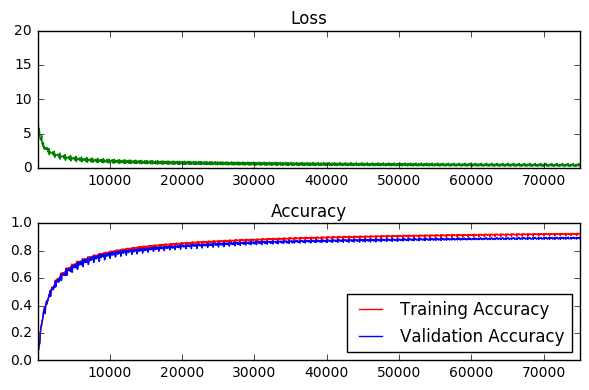

Validation accuracy at 0.8888322114944458


In [11]:
# Determine if the predictions are correct
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

# ToDo: Find the best parameters for each configuration
epochs = 100
batch_size = 50
learning_rate = 0.2



### DON'T MODIFY ANYTHING BELOW ###
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
                #print(l, training_accuracy, validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

In [12]:
# ToDo: Set the epochs, batch_size, and learning_rate with the best parameters from problem 3
epochs = 100
batch_size = 100
learning_rate = 0.2



### DON'T MODIFY ANYTHING BELOW ###
# The accuracy measured against the test set
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


assert test_accuracy >= 0.70, 'Test accuracy at {}, should be equal to or greater than 0.70'.format(test_accuracy)
print('Nice Job! Test Accuracy is {}'.format(test_accuracy))

Epoch 100/100: 100%|██████████| 373/373 [00:00<00:00, 522.39batches/s]

Nice Job! Test Accuracy is 0.7741884589195251


## Multilayer Perceptron

In [13]:
### Preprocess the data again for this model.

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def grayscale_features(X):
    X_gray = np.empty(X[:,:,:,0].shape)
    for i in range(len(X_gray)):
        X_gray[i] = grayscale(X[i])
    return(X_gray)

def flatten(X):
    features = []
    for image in X:
        feature = np.array(image, dtype=np.float32).flatten()
        features.append(feature)
    return np.array(features)

def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    # ToDo: Implement Min-Max scaling for greyscale image data
    a = 0.1
    b = 0.9
    x_min = 0
    x_max = 255
    return a + ((image_data-x_min)*(b-a))/(x_max-x_min)

# Normalize features
def normalize_rgb(image_data):
    return (image_data-128)/128

#train_features = normalize_rgb(X_train)
#test_features = normalize_rgb(X_test)

X_train_gray = grayscale_features(X_train)
X_test_gray = grayscale_features(X_test)

#X_train_flat = flatten(X_train_gray)
#X_test_flat = flatten(X_test_gray)

train_features = normalize_greyscale(X_train_gray)
test_features = normalize_greyscale(X_test_gray)

print(train_features.shape, train_features.dtype)
print(test_features.shape, test_features.dtype)
print('Images converted to greyscale and normalized.')


(39209, 32, 32) float64
(12630, 32, 32) float64
Images converted to greyscale and normalized.


In [14]:
# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
train_labels = encoder.transform(y_train)
test_labels = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
train_labels = train_labels.astype(np.float32)
test_labels = test_labels.astype(np.float32)
print(train_labels.shape, train_labels.dtype)
print(test_labels.shape, test_labels.dtype)

(39209, 43) float32
(12630, 43) float32


In [15]:
# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print(train_features.shape, train_features.dtype)
print(train_labels.shape, train_labels.dtype)
print(valid_features.shape, valid_features.dtype)
print(valid_labels.shape, valid_labels.dtype)
print(test_features.shape, test_features.dtype)
print(test_labels.shape, test_labels.dtype)
print('Training features and labels randomized and split.')

(37248, 32, 32) float64
(37248, 43) float32
(1961, 32, 32) float64
(1961, 43) float32
(12630, 32, 32) float64
(12630, 43) float32
Training features and labels randomized and split.


In [16]:
# Save the data for easy access
pickle_file = 'perceptron.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


In [17]:
%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = 'perceptron.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory

print(train_features.shape, valid_features.shape, test_features.shape)

print('Data and modules loaded.')

(37248, 32, 32) (1961, 32, 32) (12630, 32, 32)
Data and modules loaded.


In [18]:
# Parameters
learning_rate = 0.01
training_epochs = 1000
batch_size = 50
display_step = 1

n_input = 32 * 32 # German Traffic Signs Dataset input (img shape: 32*32)
n_classes = 43  # German Traffic Signs total classes (0-42 digits)
n_train_examples = train_features.shape[0]

n_hidden_layer = 256

# Store layers weight & bias
weights = {
    'hidden_layer': tf.Variable(tf.random_normal([n_input, n_hidden_layer])),
    'out': tf.Variable(tf.random_normal([n_hidden_layer, n_classes]))
}
biases = {
    'hidden_layer': tf.Variable(tf.random_normal([n_hidden_layer])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# tf Graph input
x = tf.placeholder("float", [None, 32, 32])
y = tf.placeholder("float", [None, n_classes])

x_flat = tf.reshape(x, [-1, n_input])

# Hidden layer with RELU activation
layer_1 = tf.add(tf.matmul(x_flat, weights['hidden_layer']), biases['hidden_layer'])
layer_1 = tf.nn.relu(layer_1)
# Output layer with linear activation
logits = tf.matmul(layer_1, weights['out']) + biases['out']

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# Initializing the variables
init = tf.initialize_all_variables()


# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # Training cycle
    for epoch in range(training_epochs):
        total_batch = int(n_train_examples/batch_size)+1
        train_feature_batch = np.array_split(train_features, int(n_train_examples/batch_size)+1)
        train_label_batch = np.array_split(train_labels, int(n_train_examples/batch_size)+1)
        # Loop over all batches
        for i in range(total_batch):
            batch_x = train_feature_batch[i] 
            batch_y = train_label_batch[i] 
            # Run optimization op (backprop) and cost op (to get loss value)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(c))
    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Validation Accuracy:", accuracy.eval({x: valid_features, y: valid_labels}))
    print("Test Accuracy:", accuracy.eval({x: test_features, y: test_labels}))

Epoch: 0001 cost= 12.862786293
Epoch: 0002 cost= 8.308361053
Epoch: 0003 cost= 5.725727081
Epoch: 0004 cost= 4.333859921
Epoch: 0005 cost= 3.549902201
Epoch: 0006 cost= 3.165823460
Epoch: 0007 cost= 2.891639471
Epoch: 0008 cost= 2.612096548
Epoch: 0009 cost= 2.385223389
Epoch: 0010 cost= 2.183960199
Epoch: 0011 cost= 2.021522284
Epoch: 0012 cost= 1.893853068
Epoch: 0013 cost= 1.785508871
Epoch: 0014 cost= 1.703434587
Epoch: 0015 cost= 1.622733116
Epoch: 0016 cost= 1.549025893
Epoch: 0017 cost= 1.486109376
Epoch: 0018 cost= 1.418301582
Epoch: 0019 cost= 1.360902309
Epoch: 0020 cost= 1.316951632
Epoch: 0021 cost= 1.265033126
Epoch: 0022 cost= 1.225267410
Epoch: 0023 cost= 1.188952088
Epoch: 0024 cost= 1.145552635
Epoch: 0025 cost= 1.107929945
Epoch: 0026 cost= 1.087787271
Epoch: 0027 cost= 1.059188366
Epoch: 0028 cost= 1.029940724
Epoch: 0029 cost= 1.008652806
Epoch: 0030 cost= 0.989463389
Epoch: 0031 cost= 0.968233466
Epoch: 0032 cost= 0.948595643
Epoch: 0033 cost= 0.930505335
Epoch: 00

## Convolutional Neural Net

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

print('Modules imported')


Modules imported


In [20]:
# Based on ConvNet Lecture
# Parameters
learning_rate = 0.001
batch_size = 64
training_epochs = 100

n_input = 32 * 32 # German Traffic Signs Dataset input (img shape: 32*32)
n_classes = 43  # German Traffic Signs total classes (0-42 digits)
n_train_examples = train_features.shape[0]

train_features = train_features.reshape(-1, 32, 32, 1)
valid_features = valid_features.reshape(-1, 32, 32, 1)
test_features = test_features.reshape(-1, 32, 32, 1)
print(train_features.shape, valid_features.shape, test_features.shape)

layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3': 128,
    'fully_connected': 512
}

weights = {
    'layer_1': tf.Variable(tf.truncated_normal(
        [5, 5, 1, layer_width['layer_1']], stddev=0.01)),
    'layer_2': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_1'], layer_width['layer_2']], stddev=0.01)),
    'layer_3': tf.Variable(tf.truncated_normal(
        [5, 5, layer_width['layer_2'], layer_width['layer_3']], stddev=0.01)),
    'fully_connected': tf.Variable(tf.truncated_normal(
        [4*4*128, layer_width['fully_connected']], stddev=0.01)),
    'out': tf.Variable(tf.truncated_normal(
        [layer_width['fully_connected'], n_classes], stddev=0.01))
}

biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1'])),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2'])),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
    'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected'])),
    'out': tf.Variable(tf.zeros(n_classes))
}

(37248, 32, 32, 1) (1961, 32, 32, 1) (12630, 32, 32, 1)


In [21]:
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')

In [22]:
# Create model
def conv_net(x, weights, biases, keep_prob):
    
    # Layer 1 - 32*32*1 to 16*16*32
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = maxpool2d(conv1)
    #conv1 = tf.nn.dropout(conv1, keep_prob)
    

    # Layer 2 - 16*16*32 to 8*8*64
    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    conv2 = maxpool2d(conv2)
    #conv2 = tf.nn.dropout(conv2, keep_prob)

    # Layer 3 - 8*8*64 to 4*4*128
    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
    conv3 = maxpool2d(conv3)
    #conv3 = tf.nn.dropout(conv3, keep_prob)

    # Fully connected layer - 4*4*128 to 512
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(
        conv3,
        [-1, weights['fully_connected'].get_shape().as_list()[0]])
    fc1 = tf.add(
        tf.matmul(fc1, weights['fully_connected']),
        biases['fully_connected'])
    fc1 = tf.nn.tanh(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # Output Layer - class prediction - 512 to 43
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
I experimented with multiple models in order to really learn the material. My first 2 models followed the labs provided in lecture and were able to achieve about 80% accuracy for the linear model and around 91% accuracy for the multilayer-perceptron. For the final model I experimented with a Convnet with the following architecture:
    * 3 convolution layers with L2 Regularization and max pooling
        * Layer 1 - 32*32*1 to 16*16*32
        * Layer 2 - 16*16*32 to 8*8*64
        * Layer 3 - 8*8*64 to 4*4*128 
    * 1 fully connected layer 4*4*128 to 512 with L2 Regularization and Dropout
    * output layer 512 to 43 classes

In [23]:
### Train your model here.
### Feel free to use as many code cells as needed.
# tf Graph input
x = tf.placeholder("float", [None, 32, 32, 1])
y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32) # probability to keep units

logits = conv_net(x, weights, biases, keep_prob)

y_pred = tf.nn.softmax(logits)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)\
    .minimize(cost)

saver = tf.train.Saver()
# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    checkpoint_file='convnet.ckpt'
    
    # Training cycle
    for epoch in range(training_epochs):
        total_batch = int(n_train_examples/batch_size)+1
        train_feature_batch = np.array_split(train_features, int(n_train_examples/batch_size)+1)
        train_label_batch = np.array_split(train_labels, int(n_train_examples/batch_size)+1)
        # Loop over all batches
        for i in range(total_batch):
            batch_x = train_feature_batch[i] 
            batch_y = train_label_batch[i] 
            # Run optimization op (backprop) and cost op (to get loss value)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        # Display logs per epoch step
        c = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
    print("Optimization Finished!")
    
    # Test model
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Validation Accuracy:",accuracy.eval({x: valid_features, y: valid_labels, keep_prob: 1.0}))
    print("Test Accuracy:",accuracy.eval({x: test_features, y: test_labels, keep_prob: 1.0}))

    saver.save(sess, checkpoint_file)

Epoch: 0001 cost= 3.262134552
Epoch: 0002 cost= 0.944212854
Epoch: 0003 cost= 0.364577383
Epoch: 0004 cost= 0.120024212
Epoch: 0005 cost= 0.055545691
Epoch: 0006 cost= 0.055874400
Epoch: 0007 cost= 0.045353789
Epoch: 0008 cost= 0.016303623
Epoch: 0009 cost= 0.022129612
Epoch: 0010 cost= 0.004231242
Epoch: 0011 cost= 0.003755049
Epoch: 0012 cost= 0.015631996
Epoch: 0013 cost= 0.014513584
Epoch: 0014 cost= 0.004367383
Epoch: 0015 cost= 0.019733945
Epoch: 0016 cost= 0.004696616
Epoch: 0017 cost= 0.004308157
Epoch: 0018 cost= 0.010835995
Epoch: 0019 cost= 0.001630655
Epoch: 0020 cost= 0.002172412
Epoch: 0021 cost= 0.016001625
Epoch: 0022 cost= 0.012930977
Epoch: 0023 cost= 0.028296238
Epoch: 0024 cost= 0.063475810
Epoch: 0025 cost= 0.000235277
Epoch: 0026 cost= 0.000629652
Epoch: 0027 cost= 0.000340481
Epoch: 0028 cost= 0.007537272
Epoch: 0029 cost= 0.022920098
Epoch: 0030 cost= 0.010833131
Epoch: 0031 cost= 0.003141484
Epoch: 0032 cost= 0.001489526
Epoch: 0033 cost= 0.000371321
Epoch: 003

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


### **Answer:**
I used an Adam Optimizer to train the final Convnet with a batch size of 64, 100 epochs, and a learning rate of 0.001. I had originally experimented with the Gradient Descent optimizer but it was much more susceptible to getting stuck in local minima and required a lot more hyperparameter tuning to get it just right. So I chose the Adam optimizer in the end because it gave much more consistent results that tended to converge more quickly. I tested out various hyperparameters and chose the ones that seemed to give the best accuracy on the test sets. At first I was stuck with around 5% accuracy mostly because the Gradient Descent optimizer would get stuck in a local minima. Another important consideration that helped performance was choosing the right weight values. Starting out with much smaller weights led to much faster convergence of the model and more accurate predictions in the end. Training the final model took about 3 hours to train on a CPU and returned validation accuracy of approximately 99% and test accuracy of 92%. The ConvNet performed the best out of the 3 models, and I think with further tuning it could perform even better. I hope to continue to experiment with the Convolutional Neural Net, by testing out ideas like adding additional jittered images, experimenting with more deeply connected layers, training for more epochs, randomizing the training batches, and further hyperparameter tuning.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
My approach was to experiment as much as possible with different models and discover what worked best for the given problem and understand why each model was performing the way it was. I preprocessed the images the same for each model to give a good baseline for comparison. Some of the main challenges were in understanding the proper dimensions and transformations that are taking place at each layer. However, once I understood that better, it became a fun game to test out different architectures, and figure out how to best tune their hyperparameters to get the best accuracy possible. In the end I am really impressed with the power of all these models and can't wait to spend more time exploring more convolutional neural net architectures.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)
This image is: <class 'numpy.ndarray'> with dimesions: (32, 32, 3)


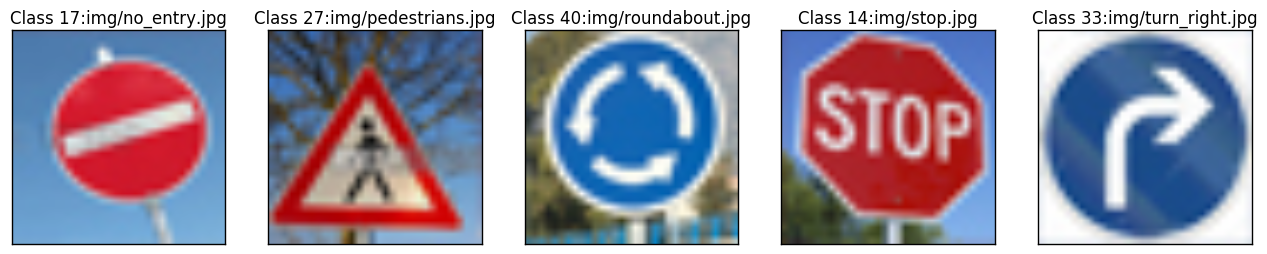

In [31]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

#create a figure to plot the images
fig = plt.figure(figsize=(16,8))

new_features_test = []

#read in the images
new_images = [('img/no_entry.jpg', 'Class 17'), ('img/pedestrians.jpg', 'Class 27'), 
             ('img/roundabout.jpg', 'Class 40'), ('img/stop.jpg', 'Class 14'), 
             ('img/turn_right.jpg', 'Class 33')]
for i, img in enumerate(new_images):
    image = mpimg.imread(img[0])
    new_features_test.append(image)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimesions:', image.shape)
    
    a=fig.add_subplot(1,5,i+1)
    a.set_xticks([])
    a.set_yticks([])
    a.set_title(img[1]+':'+img[0])
    plt.imshow(image)
    
plt.show()

In [32]:
new_features_test = np.array(new_features_test)
print(new_features_test.shape)

new_features_gray = grayscale_features(new_features_test)
#new_features_flat = flatten(new_features_gray)
new_features = normalize_greyscale(new_features_gray).reshape(-1, 32, 32, 1).astype('float32')

print(new_features.shape, new_features.dtype)
print('Images converted to greyscale and normalized.')

(5, 32, 32, 3)
(5, 32, 32, 1) float32
Images converted to greyscale and normalized.


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
I didn't choose images that would make classification particularly difficult in any way. Instead I wanted to choose fairly basic, representative images to get a sense of how well the model could perform on common data with minimal distortion. When I have more time, I think it would be really interesting to gather a large array of images in the different categories, and see which ones the network has learned better than others. I would also like to look for additional datasets of US Traffic Signs to see if the model can be transfered to different data sets or easily retrained for local roads. 
Above I have plotted the 5 new images that I chose, along with their name and class.

Session restored
Predicted classes of the new images:  [17 27 40 14 33]
Actual classes of the new images:    [17 27 40 14 33]
Validation Accuracy: 0.992861
Test Accuracy: 0.92209
New Image Accuracy:  1.0


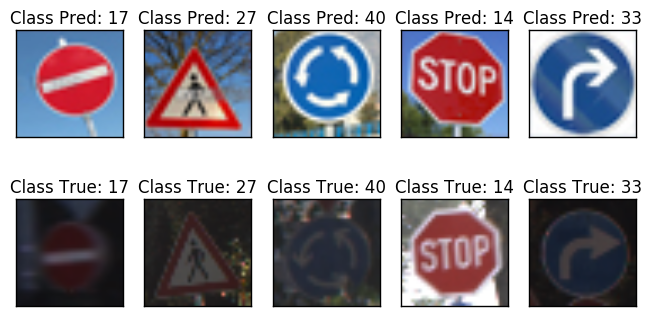

In [42]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

saver = tf.train.Saver()
checkpoint_file='convnet.ckpt'

fig2 = plt.figure(figsize=(8,4))

with tf.Session() as sess:
    saver.restore(sess, checkpoint_file)
    print("Session restored")

    classified = sess.run(y_pred, feed_dict={x:new_features, keep_prob:1.0})
    classes = np.argmax(classified, axis = 1)
    print ('Predicted classes of the new images: ', classes)
    print ('Actual classes of the new images:    [17 27 40 14 33]')
    
    print('Validation Accuracy: 0.992861')
    print('Test Accuracy: 0.92209')
    
    correct = 0
    true = [17, 27, 40, 14, 33]
    for i, v in enumerate(classes):
        if classes[i] == true[i]:
            correct += 1
    print('New Image Accuracy: ', correct/5)
    for i, v in enumerate(classes):
        a=fig2.add_subplot(2,5,i+1)
        a.set_xticks([])
        a.set_yticks([])
        a.set_title('Class Pred: {0}'.format(v))
        image_pred = mpimg.imread(new_images[i][0])
        plt.imshow(image_pred)
    for i, v in enumerate(true):
        b=fig2.add_subplot(2,5,i+6)
        b.set_xticks([])
        b.set_yticks([])
        b.set_title('Class True: {0}'.format(true[i]))
        plt.imshow(data_classes[true[i]][20])
    
plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
On my first attempt with this model it only was able to classify 2 out of the 5 images correctly despite being fairly simple images. However, this was in keeping with the accuracy that I was seeing on the validation and test sets. The test set was only getting an accuracy of around 88%. Compared to this my attempt at classifying the new images was only slightly lower at around 45% accuracy. So while my model was fitting the training data really well, it appeared to be overfit, and wasn't generalizing as well to the validation and test stes. For the first image, the model predicted that it was a stop sign instead of a no-entry sign. These are very similar to eachother but the model wasnt' able to detect the subtle differences between them. For the second image, the model predicted it was the caution sign instead of the pedestrians sign. For the third image, the model predicted the no-passing sign when it was actually the roundabout sign. And the model predicted correctly for the final two image of the stop sign and the right-turn sign. Overall, it appeared that the model was picking up on major similarities, but missing out on classifying some of the more subtle details. I think to improve it's performance, it would be important to simulate additional training images by jittering and distorting the originals. I also think that I could do more experimentation with a deeper network to capture some of the more subtle details of the images. 

**Update**
After my first submission, I was able to retrain my model for additional time by reloading the saved model and retraining over the training images again. This time it was able to achieve an accuracy of 100% on the new images. With a better fit model to the validation and testing data, the model was able to classify every image correctly. Comparing directly to the validation accuracy, the new images classified 100% correctly compared to 99% correct for the validation set and 92% correct for the test set. This is what I would have originally expected considering the basic nature of the images and the increased accuracy on training and testing data. This tells me that the model is no longer overfit and is generalizing really well to both the validation, test, and new images.

Now that I have a baseline for predicting traffic signs on images that I know to be free of distortion, I am really interested to take this model and begin to find highly distorted  or transformed images to see if the model is able to perform equally well given challenging data. It would also be interesting to choose images from only those classes that were underrepresented in the original data set to see if the model works as well for images that have much fewer training examples. Overall, I am very happy with this result though, and can't wait to gather more data and experiment more with this technique.


In [43]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import pprint

saver = tf.train.Saver()
checkpoint_file='convnet.ckpt'

with tf.Session() as sess:
    saver.restore(sess, checkpoint_file)
    print("Session restored\n")

    classified = sess.run(y_pred, feed_dict={x:new_features, keep_prob:1.0})
    classes = np.argmax(classified, axis = 1)
    print ('Predicted Classes of the new images\n', classes)
    print ('Actual classes of the new images:\n[17 27 40 14 33]')
    print()
    print ('Softmax probabilities\n', classified)
    print()
    sess.run(init)
    topFive=tf.nn.top_k(classified, k=5, sorted=True, name=None)
    prob, topk = sess.run(topFive, feed_dict = {x:new_features})
    print('Probabilities of Top 5 results\n')
    print(prob)
    print()
    print('Top 5 predicted Classes\n')
    print(topk)
    print()
    print ('Actual classes of the new images:\n [17 27 40 14 33]')
    

Session restored

Predicted Classes of the new images
 [17 27 40 14 33]
Actual classes of the new images:
[17 27 40 14 33]

Softmax probabilities
 [[  8.41659211e-16   2.49700784e-18   6.45515009e-22   9.95133857e-26
    1.86612861e-14   1.64509541e-28   6.66228163e-26   9.19659793e-20
    5.23947185e-17   8.90399264e-21   6.65351912e-26   3.24018748e-22
    1.70381771e-19   9.47341133e-20   5.32357490e-06   2.12433031e-26
    1.89761453e-21   9.99994636e-01   1.43373714e-24   2.32504900e-22
    2.17762351e-24   6.12235065e-21   7.43499257e-22   1.50055293e-28
    5.10825104e-24   1.02653095e-25   1.45162039e-20   1.99395511e-28
    1.40362468e-27   6.75848916e-30   1.86469855e-21   1.21925885e-25
    6.60940799e-24   7.92618915e-10   7.32889519e-20   6.94909403e-17
    5.43375958e-26   2.19389360e-14   4.13404061e-25   1.22252707e-12
    7.11982529e-19   4.08121686e-19   2.29711519e-26]
 [  1.11235879e-12   2.56690016e-19   8.41417284e-25   1.48772115e-29
    2.95967860e-15   1.364261

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
For my first submission 2 out of 5 new images were predicted correctly, visualizing the softmax probabilities and top 5 predictions, showed that all of the actual classes were in the top 5 predictions for the new images. For images 1, and 2 the actual class was number 2 in the top 5 predictions, and for image number 3 the actual class was number 5 in the top 5 predictions. Overall, I think this showed that the model was starting to perform well, but needed additional training data and tweaks to the architecture to get it to perform even better and make better inferences when it came to detail and distortion.

**Update**
After retraining, the model was able to predict each of the 5 images correctly, and the new softmax probabilities displayed above show that their probabilities were significantly higher than other classes in the top 5 predicted classes. This lets me know that the model is fairly robust to small differences now, and starting to pick up on smaller level details in the images. For instance, on my first submission the model was getting confused between stop signs and no-entry signs. But now, the stop sign shows up as number 2 in the top 5 predictions for the no-entry class, but there is still a significant margin to show that the model is beginning to distinguis between signs with a lot of similarity. Similarly, for other images that were mis-classified in the previous model, they are now showing up as number 1 in the top 5 predictions with a probability at or very near 1.0. This is very encouraging for continued research.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
I downloaded traffic signs from the internet, and I used OpenCV to transform them into the right dimensions to match the training and test data. Each image was converted into a 32x32 image and then I applied grayscale and normalization just like with the training set. Then I made predictions on these new images using the trained model.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.